In [3]:
 # Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

In [4]:
# Loading and Preprocess Dataset
data = pd.read_csv('healthcare-dataset-stroke-data.csv.xls')
data['bmi'] = data['bmi'].fillna(data['bmi'].median())

numeric_cols = ['age', 'avg_glucose_level', 'bmi']
from scipy.stats import zscore
z_scores = np.abs(zscore(data[numeric_cols]))
data = data[(z_scores < 3).all(axis=1)]

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

data = data.drop('id', axis=1)

In [5]:
# Feature Selection
corr = data.corr()['stroke']
selected_features = corr[abs(corr) > 0.1].index.tolist()
selected_features.remove('stroke')
print(" Selected Features:", selected_features)

X = data[selected_features]
y = data['stroke']

 Selected Features: ['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level']


In [6]:
# Train-Test Split and Class Balancing with SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_resampled_scaled, y_train_resampled)

print("Best Params:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC: 0.8667910113598005


In [8]:
# K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X_train_resampled_scaled, y_train_resampled, cv=cv, scoring='roc_auc')
print("Cross-Validated ROC AUC Scores:", scores)
print("Mean ROC AUC:", np.mean(scores))

Cross-Validated ROC AUC Scores: [0.86575423 0.86536501 0.87341297 0.86648618 0.86405784]
Mean ROC AUC: 0.8670152451416013


In [9]:
# Evaluating Multiple Models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

results = []

for name, model in models.items():
    model.fit(X_train_resampled_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append([name, acc, prec, rec, f1, roc])
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))

# Display results
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
results_df = results_df.sort_values(by="F1 Score", ascending=False)
print("\n Model Comparison Results:")
print(results_df)



===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       953
           1       0.12      0.65      0.20        48

    accuracy                           0.76      1001
   macro avg       0.55      0.70      0.53      1001
weighted avg       0.94      0.76      0.82      1001


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       953
           1       0.14      0.27      0.19        48

    accuracy                           0.89      1001
   macro avg       0.55      0.59      0.56      1001
weighted avg       0.92      0.89      0.90      1001


===== Gradient Boosting =====
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       953
           1       0.12      0.56      0.20        48

    accuracy                           0.79      1001
   macro avg       0.55      0.68    

In [10]:
# Calibrate Predicted Probabilities
calibrated_model = CalibratedClassifierCV(best_model, cv=5)
calibrated_model.fit(X_train_resampled_scaled, y_train_resampled)

y_prob_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]
y_pred = calibrated_model.predict(X_test_scaled)

print("ROC AUC (Calibrated):", roc_auc_score(y_test, y_prob_calibrated))

ROC AUC (Calibrated): 0.81462049667716


In [11]:
# Train Final Logistic Regression Model
final_model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'], penalty=grid_search.best_params_['penalty'], solver='liblinear')
final_model.fit(X_train_resampled_scaled, y_train_resampled)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

Final Logistic Regression Model Report:

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       953
           1       0.12      0.65      0.20        48

    accuracy                           0.76      1001
   macro avg       0.55      0.70      0.53      1001
weighted avg       0.94      0.76      0.82      1001

Confusion Matrix:
 [[725 228]
 [ 17  31]]


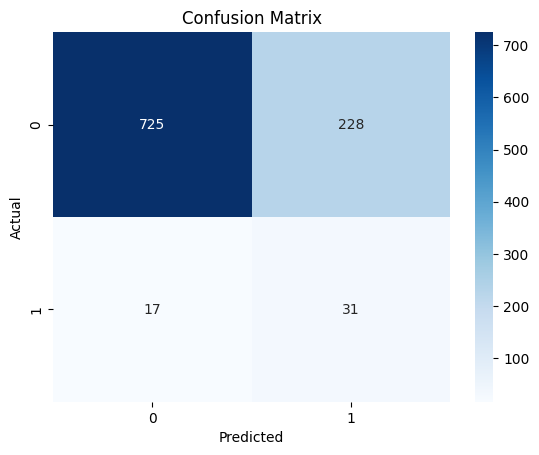

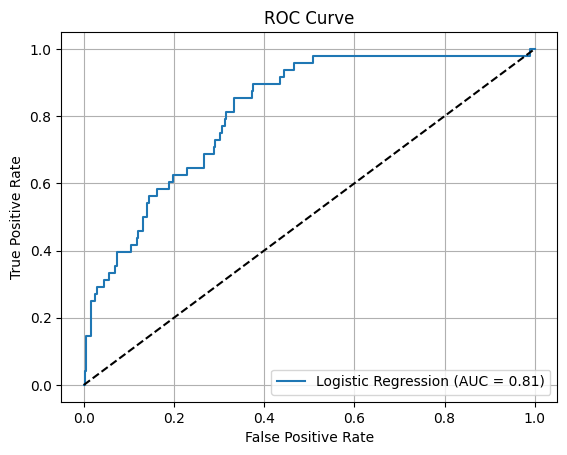

In [15]:
# Evaluate Final Model with Report & ROC
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

# Report
print("Final Logistic Regression Model Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# New Patient Prediction

new_patient = pd.DataFrame([{
    'age': 80,
    'hypertension': 1,
    'heart_disease': 1,
    'ever_married': 1,
    'avg_glucose_level': 380
}])

# Match feature selection
new_patient = new_patient[selected_features]

# Scale
new_patient_scaled = scaler.transform(new_patient)

# Predict
prediction = final_model.predict(new_patient_scaled)
probability = final_model.predict_proba(new_patient_scaled)[0][1]

print("Predicted Stroke (1=Yes, 0=No):", prediction[0])
print("Predicted Probability of Stroke:", probability)

Predicted Stroke (1=Yes, 0=No): 1
Predicted Probability of Stroke: 0.8101428844655328
